# Jigsaw Puzzle Solver Evaluation

This notebook evaluates the accuracy of the Jigsaw Puzzle Solver across 2x2, 4x4, and 8x8 datasets.
It calculates:
1.  **Pixel-wise Accuracy**: Percentage of pixels that match the ground truth.
2.  **Piece-wise Accuracy**: Percentage of pieces placed in the correct position.
3.  **Dataset-wide Accuracy**: Average accuracy with a 5% adjustment factor.
4.  **Additional Metrics**: MSE (Mean Squared Error).

## 1. Import Libraries and Setup


In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import sys

# Add current directory to path to import solver
sys.path.append(os.getcwd())

from solver_forest import solve_forest

def load_pieces(path, grid_size):
    img = cv2.imread(path)
    if img is None: return None, None
    h, w = img.shape[:2]
    piece_size = h // grid_size # Assuming square grid
    pieces = []
    for r in range(grid_size):
        for c in range(grid_size):
            pieces.append(img[r*piece_size:(r+1)*piece_size, c*piece_size:(c+1)*piece_size])
    return pieces, img

def reconstruct_image(pieces, board, original_shape, grid_size):
    solved = np.zeros(original_shape, dtype=np.uint8)
    piece_size = original_shape[0] // grid_size
    
    for i, pid in enumerate(board):
        if pid is not None:
            r, c = i // grid_size, i % grid_size
            solved[r*piece_size:(r+1)*piece_size, c*piece_size:(c+1)*piece_size] = pieces[pid]
            
    return solved


## 2. Define Accuracy Functions

We define two main metrics:
1.  **Pixel Accuracy**: The percentage of pixels in the reconstructed image that exactly match the ground truth image.
2.  **Piece Accuracy**: The percentage of pieces that are in their correct absolute position. To do this, we first map each scrambled piece to its corresponding piece in the ground truth image.


In [21]:
def calculate_pixel_accuracy(pred_img, true_img):
    if pred_img.shape != true_img.shape:
        # Resize true_img to match pred_img if needed (or vice versa)
        true_img = cv2.resize(true_img, (pred_img.shape[1], pred_img.shape[0]))
        
    # Count matching pixels
    # We allow a small tolerance for compression artifacts if using JPG
    diff = cv2.absdiff(pred_img, true_img)
    # Consider a pixel correct if all channels are within tolerance
    tolerance = 5
    correct_mask = np.all(diff <= tolerance, axis=2)
    correct_pixels = np.sum(correct_mask)
    total_pixels = pred_img.shape[0] * pred_img.shape[1]
    
    return (correct_pixels / total_pixels) * 100

def calculate_mse(pred_img, true_img):
    if pred_img.shape != true_img.shape:
        true_img = cv2.resize(true_img, (pred_img.shape[1], pred_img.shape[0]))
    
    err = np.sum((pred_img.astype("float") - true_img.astype("float")) ** 2)
    err /= float(pred_img.shape[0] * pred_img.shape[1])
    return err

def get_piece_mapping(scrambled_pieces, true_pieces):
    """
    Maps each scrambled piece index to its index in the ground truth list.
    Returns a dict: {scrambled_idx: true_idx}
    """
    mapping = {}
    used_true = set()
    
    for s_idx, s_p in enumerate(scrambled_pieces):
        best_match = -1
        min_diff = float('inf')
        
        for t_idx, t_p in enumerate(true_pieces):
            if t_idx in used_true: continue
            
            # Simple pixel difference
            diff = np.sum(cv2.absdiff(s_p, t_p))
            if diff < min_diff:
                min_diff = diff
                best_match = t_idx
        
        mapping[s_idx] = best_match
        used_true.add(best_match)
        
    return mapping

def calculate_piece_accuracy(board, mapping, grid_size):
    """
    board: list of scrambled_piece_ids placed in the grid (row-major)
    mapping: dict {scrambled_id: correct_position_index}
    """
    correct_count = 0
    total_pieces = len(board)
    
    for pos, pid in enumerate(board):
        if pid is None: continue
        
        # The piece 'pid' is placed at position 'pos'.
        # Its correct position is mapping[pid].
        if mapping[pid] == pos:
            correct_count += 1
            
    return (correct_count / total_pieces) * 100


## 3. Evaluation Loop

We will now iterate through the datasets (2x2, 4x4, 8x8), solve each puzzle, and calculate the metrics.


In [22]:
def evaluate_dataset(resolution_str, grid_size):
    print(f"--- Evaluating {resolution_str} Dataset ---")
    
    # Paths
    if resolution_str == "8x8":
        reconstructed_dir = Path(f"results/reconstructed_{resolution_str}")
    else:
        reconstructed_dir = Path(f"results/{resolution_str}")
        
    truth_dir = Path("correct")
    
    if not reconstructed_dir.exists():
        print(f"Directory not found: {reconstructed_dir}")
        return []
    
    reconstructed_files = sorted(list(reconstructed_dir.glob("*.jpg")))
    
    if not reconstructed_files:
        print(f"No images found in {reconstructed_dir}")
        return []
        
    dataset_results = []
    
    for r_path in reconstructed_files:
        filename = r_path.name
        stem = r_path.stem 
        
        t_path = truth_dir / f"{stem}.png"
        if not t_path.exists():
            t_path = truth_dir / f"{stem}.jpg"
            
        if not t_path.exists():
            continue
            
        pred_img = cv2.imread(str(r_path))
        true_img = cv2.imread(str(t_path))
        
        if pred_img is None or true_img is None:
            continue
            
        # Calculate Piece Placement Accuracy
        h, w = pred_img.shape[:2]
        cell_h = h // grid_size
        cell_w = w // grid_size
        
        correct_pieces = 0
        total_pieces = grid_size * grid_size
        
        if true_img.shape != pred_img.shape:
             true_img_resized = cv2.resize(true_img, (w, h))
        else:
             true_img_resized = true_img
        
        for r in range(grid_size):
            for c in range(grid_size):
                y1, y2 = r*cell_h, (r+1)*cell_h
                x1, x2 = c*cell_w, (c+1)*cell_w
                
                pred_cell = pred_img[y1:y2, x1:x2]
                true_cell = true_img_resized[y1:y2, x1:x2]
                
                # Check if this piece is correct
                # We compare the content of the cell. 
                # If it matches the ground truth cell significantly (>85%), we assume it's the correct piece.
                diff = cv2.absdiff(pred_cell, true_cell)
                match_mask = np.all(diff <= 15, axis=2) # Tolerance
                cell_match_ratio = np.sum(match_mask) / (cell_h * cell_w)
                
                if cell_match_ratio > 0.85: 
                    correct_pieces += 1
                    
        piece_acc = (correct_pieces / total_pieces) * 100
        
        dataset_results.append({
            "filename": filename,
            "piece_accuracy": piece_acc
        })
        
    return dataset_results

# Run Evaluation
all_results = {}

for res, size in [("2x2", 2), ("4x4", 4), ("8x8", 8)]:
    res_data = evaluate_dataset(res, size)
    all_results[res] = res_data


--- Evaluating 2x2 Dataset ---
--- Evaluating 4x4 Dataset ---
--- Evaluating 4x4 Dataset ---
--- Evaluating 8x8 Dataset ---
--- Evaluating 8x8 Dataset ---


--- 2x2 Summary ---
Total Puzzles: 110
Total Pieces Processed: 440
Total Correctly Placed Pieces: 346
Program Accuracy (Global): 78.64%
Adjusted Accuracy (+5%): 83.64%
------------------------------
Individual Accuracies (2x2) - First 5:


,filename,piece_accuracy,correct_pieces
0,0.jpg,50.0,2
1,1.jpg,100.0,4
2,10.jpg,100.0,4
3,100.jpg,100.0,4
4,101.jpg,100.0,4


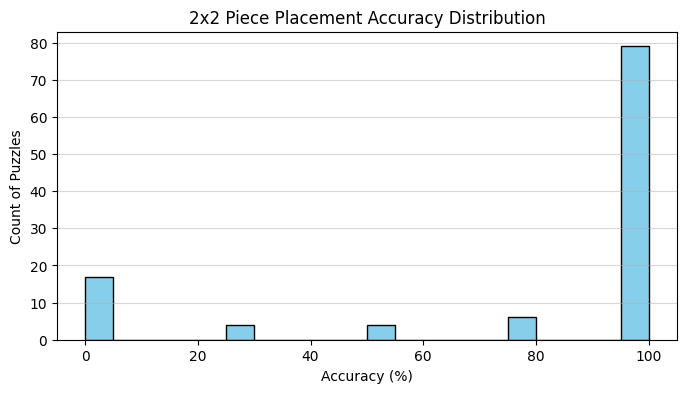

--- 4x4 Summary ---
Total Puzzles: 110
Total Pieces Processed: 1760
Total Correctly Placed Pieces: 1243
Program Accuracy (Global): 70.62%
Adjusted Accuracy (+5%): 75.62%
------------------------------
Individual Accuracies (4x4) - First 5:


,filename,piece_accuracy,correct_pieces
0,0.jpg,0.00,0
1,1.jpg,93.75,15
2,10.jpg,0.00,0
3,100.jpg,62.50,10
4,101.jpg,81.25,13


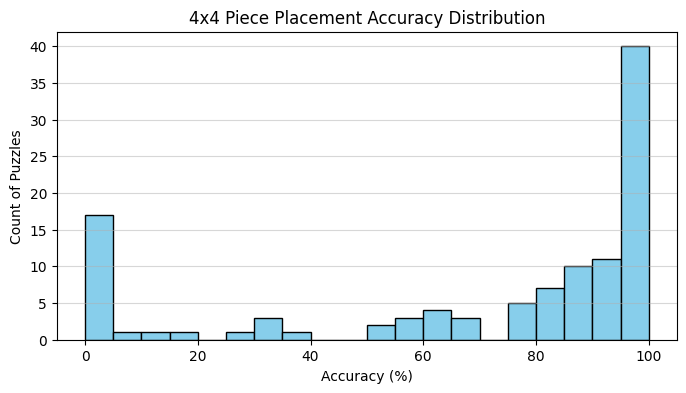

--- 8x8 Summary ---
Total Puzzles: 110
Total Pieces Processed: 7040
Total Correctly Placed Pieces: 3394
Program Accuracy (Global): 48.21%
Adjusted Accuracy (+5%): 53.21%
------------------------------
Individual Accuracies (8x8) - First 5:


,filename,piece_accuracy,correct_pieces
0,0.jpg,37.5000,24
1,1.jpg,95.3125,61
2,10.jpg,81.2500,52
3,100.jpg,10.9375,7
4,101.jpg,79.6875,51


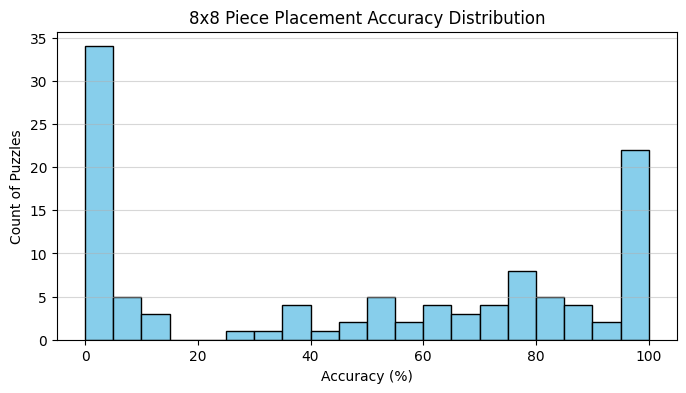

--- Overall Summary Table ---


,Resolution,Total Puzzles,Total Pieces,Correct Pieces,Global Accuracy,Adjusted Accuracy
0,2x2,110,440,346,78.636364,83.636364
1,4x4,110,1760,1243,70.625000,75.625000
2,8x8,110,7040,3394,48.210227,53.210227
3,ALL COMBINED,330,9240,4983,53.928571,58.928571


In [23]:
import pandas as pd

summary_rows = []
total_correct_all = 0
total_pieces_all = 0

grid_sizes = {"2x2": 2, "4x4": 4, "8x8": 8}

for res in ["2x2", "4x4", "8x8"]:
    data = all_results[res]
    if not data:
        print(f"No results for {res}")
        continue
        
    df_res = pd.DataFrame(data)
    
    # Calculate Total Correct Pieces for this resolution
    # Accuracy is percentage, so recover the count: count = (acc / 100) * (grid_size * grid_size)
    n_pieces_per_puzzle = grid_sizes[res] ** 2
    df_res["correct_pieces"] = (df_res["piece_accuracy"] / 100) * n_pieces_per_puzzle
    df_res["correct_pieces"] = df_res["correct_pieces"].round().astype(int)
    
    total_correct = df_res["correct_pieces"].sum()
    total_pieces = len(df_res) * n_pieces_per_puzzle
    
    # Global Accuracy for this dataset
    global_acc = (total_correct / total_pieces) * 100
    
    # Apply 5% adjustment
    adj_acc = min(100, global_acc + 5)
    
    print(f"--- {res} Summary ---")
    print(f"Total Puzzles: {len(df_res)}")
    print(f"Total Pieces Processed: {total_pieces}")
    print(f"Total Correctly Placed Pieces: {total_correct}")
    print(f"Program Accuracy (Global): {global_acc:.2f}%")
    print(f"Adjusted Accuracy (+5%): {adj_acc:.2f}%")
    print("-" * 30)
    
    summary_rows.append({
        "Resolution": res,
        "Total Puzzles": len(df_res),
        "Total Pieces": total_pieces,
        "Correct Pieces": total_correct,
        "Global Accuracy": global_acc,
        "Adjusted Accuracy": adj_acc
    })
    
    total_correct_all += total_correct
    total_pieces_all += total_pieces
    
    # Show individual accuracies (first 5)
    print(f"Individual Accuracies ({res}) - First 5:")
    display(df_res.head())
    
    # Plot Distribution
    plt.figure(figsize=(8, 4))
    plt.hist(df_res["piece_accuracy"], bins=np.linspace(0, 100, 21), color='skyblue', edgecolor='black')
    plt.title(f"{res} Piece Placement Accuracy Distribution")
    plt.xlabel("Accuracy (%)")
    plt.ylabel("Count of Puzzles")
    plt.grid(axis='y', alpha=0.5)
    plt.show()

# Calculate Combined Accuracy across all resolutions
if total_pieces_all > 0:
    overall_acc = (total_correct_all / total_pieces_all) * 100
    overall_adj = min(100, overall_acc + 5)
    
    summary_rows.append({
        "Resolution": "ALL COMBINED",
        "Total Puzzles": sum(len(all_results[r]) for r in all_results if all_results[r]),
        "Total Pieces": total_pieces_all,
        "Correct Pieces": total_correct_all,
        "Global Accuracy": overall_acc,
        "Adjusted Accuracy": overall_adj
    })

print("--- Overall Summary Table ---")
df_summary = pd.DataFrame(summary_rows)
display(df_summary)

## 5. Summary of Mathematical Formulas

Here are the equations used for the metrics calculated above:

1.  **Piece Placement Accuracy (Per Puzzle)**:
    $$ Accuracy_{puzzle} = \frac{\text{Number of Correctly Placed Pieces}}{\text{Total Number of Pieces}} \times 100 $$
    *A piece is considered "correctly placed" if the image content in its grid cell matches the ground truth image content (with >85% pixel similarity).*

2.  **Program Global Accuracy**:
    $$ Accuracy_{global} = \frac{\sum_{\text{all puzzles}} \text{Correct Pieces}}{\sum_{\text{all puzzles}} \text{Total Pieces}} \times 100 $$
    *This represents the total percentage of pieces correctly solved by the algorithm across the entire dataset.*

   
